<a href="https://colab.research.google.com/github/dddonghwa/IAB/blob/main/Computer-Vision/5_CIFAR10_CNN_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch를 이용해서 CIFAR 10 이미지 분류 해보기

# 딥러닝 모델을 학습시키기 위해 준비되어야 할 4가지 요소

1. 데이터
2. 모델
3. Loss function (손실함수, 목적함수, objective function 등으로 불려요): 정답과 모델의 예측값을 어떤 식으로 비교할지 결정해주는 함수
4. Optimizer: gradient descent를 해줄 애. 즉, 모델의 파라미터를 어느 방향으로 조금 수정할지 결정하고 수정해주는 함수

In [1]:
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

## 모델에 데이터 넣을 준비하기

우선 사용하고 싶은 데이터 파일이 있다면 그걸 우선 numpy array 형식으로 불러와야 해요<br/>
그리고는 필요한 전처리를 해준 후에 이 numpy array를 `torch.*Tensor` 형식으로 변환하고 <br/>
dataloader에 넣어주면 pytorch로 짠 딥러닝 모델에 넣을 준비가 된 것입니다.<br/>

대개 이제 이런 데이터 처리를 도와주는 패키지들이 있는데<br/>
이미지는 openCV, Pillow를 많이 쓰고,<br/>
텍스트에는 SpaCy를 많이 사용해요. <br/>

그런데 pytorch에서 고맙게도 그 데이터를 불러오고 전처리를 하는 걸<br/>
파이토치와 매끄럽게 잘 이어지도록 도와주는 패키지를 만들었놨어요.<br/>
* [torchvision](https://pytorch.org/docs/stable/torchvision/index.html#)
* [torchtext](https://torchtext.readthedocs.io/en/latest/)

몇몇 대표 데이터셋들은 해당 패키지에 이미 들어있어서<br/>
그냥 가져다 불러와서 쓰고 몇몇 처리만 해주면 사용할 준비가 끝나요!

이번에는 CIFAR 10이라는 데이터셋을 사용합니다.<br/>
이는 대표적인 데이터셋 중 하나라서 기억해두시면 이따금씩 보일 거예요.<br/>
클래스가 10개라서 CIFAR 10입니다.<br/>

들어있는 클래스는<br/>
‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’ 입니다.<br/>
size는 3x32x32이고 앞의 3은 RGB여서 그런 거예요.<br/>

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# 이미지는 RGB  3가지의 채널로 이루어져있으므로, 각 채널에 대한 mean, std를 넣어줘서 normalize해줘야 해요
# 이미지 데이터의 값이 0~1 사이였는데 이를 통해 -1 ~ +1 사이로 변환해줍니다.

batchsize = 16

# 너무나 간단합니다. torchvision에 이미 다 알아서 처리가 되어있어서 이렇게 편하게 불러올 수 있는 거예요!
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=2)

# 이런 클래스들이 데이터셋 안에 있습니다.
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 학습 이미지 예시 보기

32x32짜리 이미지라서 화질이 안 좋은 건 자연스러운 일입니다... <br/>
놀랍게도 이런 이미지들로 학습을 합니다.

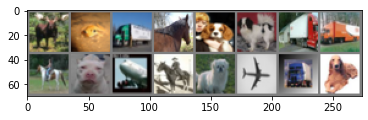

정답: deer  		  frog  		 truck  		 horse


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # 아까 앞에서 normalize해줘서 색깔 이미지가 이상해져있을 거기 때문에 보기 편하라고 다시 unnormalize해줍니다
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print( '정답:' + '  \t\t '.join('%5s' % classes[labels[j]] for j in range(4)))

## 모델 정의하기

앞선  notMNIST는 흑백 이미지라서 채널이 1개였지만 <br/>
여기서는 컬러 이미지라서 채널이 3개라는 거에 유의합니다.

In [4]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # zero padding, 3 RGB channel, 6 filter depths, 5X5 filter size
        self.conv1 = nn.Conv2d(3, 6, 5, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        ############### fc layer를 완성해보세요 ################
        # [32,32,3] =(conv2d)=> [30,30,6]
        # [30,30,6] =(pool)=> [15,15,6]
        # [15,15,6] =(relu)=> [15,15, 6]
        self.fc1 = nn.Linear(15*15*6 , 10)
        
        ########################################################

    def forward(self, x):
        # x = self.conv1(x)
        # x = self.relu(x)
        # x = self.pool(x)
        
        # 위를 압축해서 쓴 게 아래 줄이에요!
        x = self.pool(self.relu(self.conv1(x)))
        
        ############### 빈칸을 완성 해보세요 ################
        
        x = x.view(-1, 15*15*6)  # 얘의 기능은 텐서의 모양을 원하는 모양으로 바꿔주는 거예요
        # 그냥 예시: x가 만약 (16, 3, 12, 12) 모양이었다면 x.view(-1, 144)는 (48, 144) 모양으로 바꿔준답니다. -1은 나머지 숫자를 자동으로 채워주는 역할이에요
        
        ########################################################
        x = self.fc1(x)

        return x


net = Net()

## Loss function과 Optimizer 정의하기

Cross-entropy loss function과 SGD optimizer를 씁니다.


In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)  # Learning rate: 학습률. 한 번의 optimizer step에서 얼마나 멀리 갈지. 

## 모델 학습시키기

이제
* data loader
* model
* loss function
* optimizer

이 4가지가 모두 준비되었으니 학습을 할 준비가 끝났습니다.

```
종료 조건 만족할 때까지 아래를 반복:
    1. 우리의 data loader로부터 데이터를 받아와서 모델에 넣어주고
    2. 모델의 출력 값을 받아서 
    3. loss function 값을 계산하고
    4. 그 loss를 바탕으로 backprop(=gradient를 계산) 해준 뒤 
    5. optimizer가 gradient descent를 1 step 진행합니다.
    ```

### 근데...

학습을 하면서 테스트셋 성적이 어떻게 변하는지를 보는 건 어때요?

In [6]:
training_loss_history = []
test_loss_history = []

In [7]:
for epoch in range(2):  # 전체 데이터셋을 몇 번 반복할 건지

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # trainloader로부터 데이터와 라벨을 받아옵니다.
        inputs, labels = data

        # 매 반복마다 이전 gradient를 한 번 지워줍니다.
        optimizer.zero_grad()

        # 모델에 데이터 넣어서 forward 해주고 
        # backprop으로 이번 input에 대해 gradient를 계산해주고
        # optimizer가 gradient descent 1스텝 진행
        # print(inputs.shape, labels.shape)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 결과치 화면에 뿌려주기
        running_loss += loss.item()
        if i % 200 == 199:    # 2000 미니배치마다 출력
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))

            # 나중에 시각화를 위해 중간중간 따로 loss값 저장
            training_loss_history.append(running_loss / 200)
            
            with torch.no_grad():
                running_test_loss = 0.0
                for i, test_data in enumerate(testloader, 0):
                    test_images, test_labels = test_data
                    test_outputs = net(test_images)
                    test_loss = criterion(test_outputs, test_labels)
                    running_test_loss += test_loss.item()
                
                test_loss_history.append(running_test_loss / i)
                    
            running_loss = 0.0
                    
print('학습 끝!')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,   200] loss: 1.982
[1,   400] loss: 1.728
[1,   600] loss: 1.652
[1,   800] loss: 1.617
[1,  1000] loss: 1.610
[1,  1200] loss: 1.584
[1,  1400] loss: 1.551
[1,  1600] loss: 1.541
[1,  1800] loss: 1.496
[1,  2000] loss: 1.530
[1,  2200] loss: 1.483
[1,  2400] loss: 1.540
[1,  2600] loss: 1.477
[1,  2800] loss: 1.458
[1,  3000] loss: 1.495
[2,   200] loss: 1.403
[2,   400] loss: 1.383
[2,   600] loss: 1.404
[2,   800] loss: 1.379
[2,  1000] loss: 1.377
[2,  1200] loss: 1.417
[2,  1400] loss: 1.415
[2,  1600] loss: 1.401
[2,  1800] loss: 1.407
[2,  2000] loss: 1.442
[2,  2200] loss: 1.369
[2,  2400] loss: 1.415
[2,  2600] loss: 1.365
[2,  2800] loss: 1.410
[2,  3000] loss: 1.413
학습 끝!


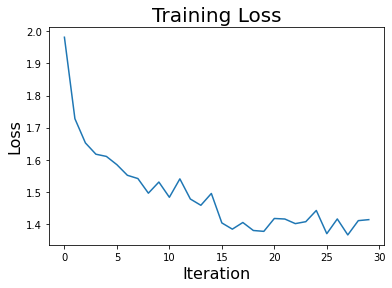

In [8]:
plt.plot(training_loss_history) 
plt.title('Training Loss', fontsize=20)  # 여기에 한글을 넣고 싶으시다구요? 그럼 좀 귀찮은 몇 가지 작업들을 해야 합니다... 그러므로 패스
plt.xlabel('Iteration',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.show()

[그래도 난 matplotlib에 한글을 넣겠어!](https://programmers.co.kr/learn/courses/21/lessons/950)

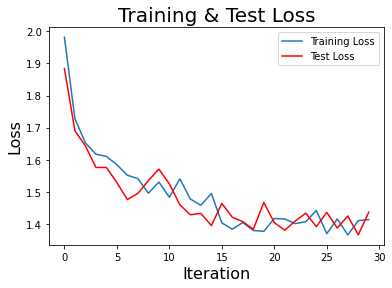

In [9]:
plt.plot(training_loss_history, label="Training Loss") 
plt.plot(test_loss_history, 'r', label="Test Loss") 
plt.title('Training & Test Loss', fontsize=20) 
plt.xlabel('Iteration',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.show()

## 모델 저장하기

학습이 끝난 모델의 파라미터를 저장해두면 나중에 필요할 때 불러와서 가져다 쓰면 바로 사용할 수 있어요.

In [10]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 테스트셋에 검증해보기

이제 모델 학습이 끝났으니 테스트 데이터에도 잘하는지 확인을 해봐야 합니다. <br/>
테스트셋 데이터 중 몇 개나 맞히는지 알아볼까요?

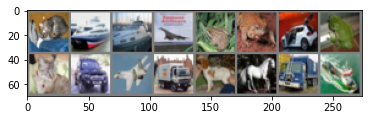

In [11]:
# 테스트셋 이미지 예시도 심심풀이로 한 번 확인해보기
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=2)
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

### 아까 저장해뒀던 모델 파라미터 불러오기

사실 굳이 불러오지 않고 그냥 위에 있는 `net` 그대로 써도 되지만 <br/>
일단 어떻게 저장하고 불러오는지 여러분이 알아둬야 하니까 여기서는 `net`에 굳이 다시 불러와봤어요

In [12]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

이미지들을 넣었을 때 모델이 뭐라고 예측하는지 한 번 확인해볼게요.

In [13]:
outputs = net(images)
outputs

tensor([[ 5.7694e-01, -1.6481e+00,  1.7576e+00,  2.2508e+00, -7.8417e-01,
          3.1375e+00, -1.1853e+00, -3.6595e+00,  2.3577e+00, -1.7799e+00],
        [ 6.6164e+00,  8.2050e+00, -1.0606e+00, -5.3304e+00, -5.6201e+00,
         -5.1118e+00, -5.1703e+00, -6.6321e+00,  9.5842e+00,  4.2070e+00],
        [ 3.0254e+00,  1.3560e+00,  3.8057e-01,  8.1075e-01, -3.9088e+00,
         -1.4554e+00, -4.1560e+00, -1.6801e+00,  4.1485e+00,  1.2216e+00],
        [ 3.5342e+00,  2.0096e+00,  1.8621e+00, -1.5770e+00, -2.2177e+00,
         -3.8385e+00, -1.5449e+00, -3.5559e+00,  4.0255e+00,  1.4982e+00],
        [-2.2623e+00, -1.4837e+00,  2.1377e+00,  1.0276e+00,  2.3894e+00,
          1.1782e+00,  2.4943e+00, -1.2495e+00, -1.8785e+00, -2.5658e+00],
        [-3.4653e-01, -4.2767e-01,  3.3689e-01,  4.1344e-02,  2.0546e-01,
          4.1414e-01,  1.7325e+00, -7.3217e-01, -9.1952e-01, -8.2575e-01],
        [ 7.8861e-01,  6.1589e+00,  7.8554e-01,  1.7671e+00, -4.4828e+00,
          2.9658e+00, -2.3826e+0

뭔지 전혀 모르겠죠? <br/>
각 row에 있는 숫자들은 10개의 클래스에 대한 logit 값이에요. (확률 값이 아니라) <br/>
어떤 인덱스의 logit값이 크면 모델은 그 해당 인덱스의 클래스로 해당 이미지를 분류한다는 의미입니다. <br/>
따라서 그냥 이 logit 값들 중 제일 큰 logit이 있는 index를 각 row마다 뽑아오면 됩니다. <br/>

In [14]:
_, predicted = torch.max(outputs, 1)  # 1번째 차원(=각 row)에서 각각 max인 값과 해당 index를 뽑아옵니다.

print('모델 예측: ', ', '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

모델 예측:    dog,  ship,  ship,  ship


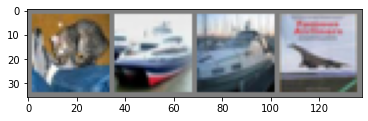

실제 정답:    cat,  ship,  ship, plane
모델 예측:    dog,  ship,  ship,  ship


In [15]:
# 원래 이미지랑 같이 볼까요?
imshow(torchvision.utils.make_grid(images[:4]))
print('실제 정답: ', ', '.join('%5s' % classes[labels[j]] for j in range(4)))
print('모델 예측: ', ', '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

나름 잘 맞히는 거 같습니다. <br/>
그러면 이제 전체 테스트셋에 대해 정답과 비교해서 몇 개나 맞히는지 보겠습니다. 

### 테스트셋 정답률 확인해보기

In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('10000개의 테스트 이미지에 대한 정답률: %d %%' % (
    100 * correct / total))

10000개의 테스트 이미지에 대한 정답률: 52 %


### 각 클래스 별 정답률 확인해보기

In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():  # 매우매우 중요! 테스트셋으로 학습하는 건 반칙입니다. 테스트셋으로 backprop을 하면 안 되지요.
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('%5s 클래스의 정답률 : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

plane 클래스의 정답률 : 60 %
  car 클래스의 정답률 : 73 %
 bird 클래스의 정답률 : 43 %
  cat 클래스의 정답률 : 39 %
 deer 클래스의 정답률 : 38 %
  dog 클래스의 정답률 : 39 %
 frog 클래스의 정답률 : 45 %
horse 클래스의 정답률 : 56 %
 ship 클래스의 정답률 : 66 %
truck 클래스의 정답률 : 44 %


# 과제:

### 1.ipynb 파일 제출 (10점)
convolution layer **2층** 이상의 convnet을 만들어서 <br/>
테스트 데이터에 대한 정답률을 높여서 ipynb 파일을 제출을 하시면 됩니다! <br/>
모델을 정의하고 이것저것 바꿔보세요. <br/>
**55%**를 넘겨보도록 해보세요!

- 55%를 넘기시면 8점
- 57.5%를 넘기시면 9점
- 60%를 넘기시면 10점

수업 시간에 말한 거 이외의 힌트:<br/>
`self.conv2`가 있어야겠죠 2층을 쌓으려면? <br/>
이건 weight기 때문에 따로 별도로 `self.conv2`가 있어야 하지만 relu나 maxpool은 파라미터가 없기 때문에 있는 거 그대로 쓰시면 되는 거예요! <br/>
과제에서 반드시 convolution layer를 2층 이상을 쌓으셔야 해요. 거기에 추가로 fc layer도 더 쌓으실 수도 있겠죠? <br/>

### 2.실험 결과 설명 제출 (5점)
Learning rate를 크게 해서 돌려보기도 하고 작게 해서 돌려보기도 하면서 각각의 training loss graph를 비교해보세요.<br/>
앞에서 한 것처럼 그래프를 그려보세요. 각 실험에 대한 graph가 노트북 파일 내에 남아있어야 해요. <br/>
그리고 그 성능에 차이가 나는 이유를 생각해서 써보세요. 

## 주의사항
ipynb 파일의 이름은 `[학번]_[이름].ipynb`로 제출하셔야 합니다. 예시: `2019-12321_김학생.ipynb`<br/>
형식을 지키지 않으실 경우 감점 1점 있습니다.

## 실험 결과 설명 작성하는 칸

여기에 작성하세요

## [덧] GPU 위에서 학습하기

지금까지는 cpu위에서 다 계산을 한 거예요.<br/>
GPU 위에서 저희 모델이 인풋 데이터를 받아서 출력을 계산하고 싶잖아요? <br/>
그러면 해야 할 일은<br/>
모델도 gpu에 보내고, 데이터도 gpu에 보내는 일입니다.<br/>

그러기 위해선 일단 gpu가 사용 가능한지부터 봐야겠죠?<br/>
CUDA available:



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# CUDA가 있는 컴퓨터라면 CUDA 라고 뜨고 아니면 cpu라고 뜰 겁니다
print(device)

The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

아래처럼 수정을 해주면 모델이 gpu 위에 올라갑니다

```python
net = net.to(device)
```

데이터도 올려줘야겠죠?

```python
inputs, labels = data[0].to(device), data[1].to(device)
 ```

지금은 모델이 너무 작아서 gpu에서 하든 cpu에서 하든 속도 차이가 별로 없습니다.